In [2]:
using Flux
using MLDatasets
using Random

In [3]:
train_x, train_y = CIFAR10.traindata(Float32, 1:5000)
test_x, test_y = CIFAR10.testdata(Float32, 1:5000);

In [3]:
println("Size of each image: ", size(train_x))
println("Label of 50th training datapoint: ", train_y[50])
# So here we can see that each training point is a 3D array - a 32x32 image with 3 color channels

Size of each image: (32, 32, 3, 10000)
Label of 50th training datapoint: 0


In [9]:
# Since this is a multi-class classification problem, we can use one hot encoding, just like the MNIST dataset.
# There's 10 classes just like mnist, so we encode from 0 to 9

train_y, test_y = Flux.onehotbatch(train_y, 0:9), Flux.onehotbatch(test_y, 0:9)
nclasses = length(train_y[:,1])
println("number of classes: ", nclasses)

number of classes: 10


In [10]:
# 3 VGG Block
model_VGG3 = Chain(
              Conv((3,3), 3=>32, relu, pad=SamePad()),
              Conv((3,3), 32=>32, relu, pad=SamePad()),
              MaxPool((2,2)),
              Dropout(0.2),
              Conv((3,3), 32=>64, relu, pad=SamePad()),
              Conv((3,3), 64=>64, relu, pad=SamePad()),
              MaxPool((2,2)),
              Dropout(0.2),
              Conv((3,3), 64=>128, relu, pad=SamePad()),
              Conv((3,3), 128=>256, relu, pad=SamePad()),
              MaxPool((2,2)),
              Dropout(0.2),
              Flux.flatten,
              Dense(4096,128,relu),
              Dropout(0.2),
              Dense(128,10),
              softmax)

Chain(
  Conv((3, 3), 3 => 32, relu, pad=1),   # 896 parameters
  Conv((3, 3), 32 => 32, relu, pad=1),  # 9_248 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((3, 3), 32 => 64, relu, pad=1),  # 18_496 parameters
  Conv((3, 3), 64 => 64, relu, pad=1),  # 36_928 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
  Conv((3, 3), 128 => 256, relu, pad=1),  # 295_168 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Flux.flatten,
  Dense(4096, 128, relu),               # 524_416 parameters
  Dropout(0.2),
  Dense(128, 10),                       # 1_290 parameters
  NNlib.softmax,
)                   # Total: 16 arrays, 960_298 parameters, 3.666 MiB.

In [11]:
function loss_and_accuracy(udata, wdata, model)

    ndata = size(udata,4)

    ŵ = model(udata)
    loss = Flux.crossentropy(ŵ, wdata; agg=sum)
    accuracy = sum(Flux.onecold(ŵ) .== Flux.onecold(wdata)) / ndata
    return loss, accuracy
end

loss_and_accuracy (generic function with 1 method)

In [12]:
batch_size = 256
train_loader = Flux.Data.DataLoader((train_x, train_y), batchsize=batch_size, shuffle=true);

In [13]:
function train(model,train_loader,train_x,train_y,test_x,test_y,model_name)
    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []
    opt = ADAM(0.001)
    K = 10
    for k in 1:K
        for (u, w) in train_loader
            gs = gradient(() -> Flux.Losses.crossentropy(model(u), w), Flux.params(model)) # compute gradient
            Flux.Optimise.update!(opt, Flux.params(model), gs) # update parameters
        end
        println("Epoch $k for $model_name architecture.")
        train_loss, train_acc = loss_and_accuracy(train_x, train_y,  model)

        test_loss, test_acc = loss_and_accuracy(test_x, test_y, model)

        println("  train_loss = $train_loss, train_accuracy = $train_acc")
        println("  test_loss = $test_loss, test_accuracy = $test_acc")
        
        push!(test_losses, test_loss)
        push!(test_accuracy, test_acc)
        push!(train_losses, train_loss)
        push!(train_accuracy, train_acc)
    end
    return train_losses, train_accuracy, test_losses, test_accuracy
end

train (generic function with 1 method)

In [9]:
function to_model(vector)
    # while of course we could make something fancy out of this, for now 
    # let's just have it encode back to our original model
    # if we were building a library or something we'd store more information about the
    # original model to not have to rebuild it like this
    return Chain(
              Conv((3,3), 3=>32, relu, pad=SamePad(), weight=reshape(vector[1:864],(3,3,3,32)), bias=vector[865:896]),# 896 - 32 bias 864
              Conv((3,3), 32=>32, relu, pad=SamePad(),weight=reshape(vector[897:10112],(3,3,32,32)), bias=vector[10112:10143]),# 9248 - 32 bias 9216
              MaxPool((2,2)),
              Dropout(0.2),
              Conv((3,3), 32=>64, relu, pad=SamePad(), weight=reshape(vector[10144:28575], (3,3,32,64)), bias=vector[28575:28638]), # 18496 - 64 = 18432 
              Conv((3,3), 64=>64, relu, pad=SamePad(), weight=reshape(vector[28639:65502], (3,3,64,64)), bias=vector[65503:65566]), # 36928 - 64 = 36864
              MaxPool((2,2)),
              Dropout(0.2),
              Conv((3,3), 64=>128, relu, pad=SamePad(),weight=reshape(vector[65568:139295], (3,3,64,128)), bias=vector[139296:139423]), # 73856 - 128 = 73728
              Conv((3,3), 128=>256, relu, pad=SamePad(),weight=reshape(vector[139424:434335], (3,3,128,256)), bias=vector[434336:434591]), # 295168 - 256 = 294912
              MaxPool((2,2)),
              Dropout(0.2),
              Flux.flatten,
              Dense(reshape(vector[434592:958879],(128,4096)),vector[958880:959007],relu), # 524416 - 128 bias = 524288
              Dropout(0.2),
              Dense(reshape(vector[959008:960287], (10,128)),vector[960288:960297],relu)) # 1290 - 10 bias = 1280
end

to_model (generic function with 1 method)

In [10]:
mutable struct Particle 
    position::Vector{Float32}
    best_position::Vector{Float32}
    best_accuracy::Float32
    velocity::Vector{Float32}
end

In [11]:
function train_PSO(model,train_loader,train_x,train_y,test_x,test_y, numparticles, ω, c1,c2)
    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []
    particles = []
    best_loss, best_accuracy = loss_and_accuracy(train_x, train_y,  model)
    
    params = Flux.params(model)
    params_flattened = []
    
    for p in params
        flattened = flatten(p)
        final = reshape(flattened, (1, size(flattened, 1) * size(flattened,2)))
        append!(params_flattened, final)
    end
    
    swarm_best_position = params_flattened
    d = size(params_flattened)
    
    #init particles
    for n in 1:numparticles
        push!(particles, Particle(params_flattened,params_flattened,best_accuracy,rand(Float32,size(params_flattened))))
    end

    println("Initalized particles!")
    
    for k in 1:3
        for (u, w) in train_loader
            for p in particles
                # vector math for additional speed boost
                # ω - inertia weight, how much the previous velocity impacts the current position
                # c1 - how much the particle pays attention to its own best position
                # c2 - how much the particle pays attention to the swarm's best position
                p.velocity = (ω .* p.velocity) .+
                (rand((-1.0,1.0),d) * c1 .* (p.best_position .- p.position)) .+
                (rand((-1.0,1.0),d) * c2 .* (swarm_best_position .- p.position))
                # need to make sure that these values are always between -1.0 and 1
                # clamp. broadcasts to entire vector
                p.position = clamp.(p.position .+ p.velocity,0.0,1.0)
            
                moved_model = to_model(p.position)
                this_loss, this_acc = loss_and_accuracy(train_x,train_y, moved_model)
                
                if p.best_accuracy < this_acc
                    p.best_accuracy = this_acc
                    p.best_position = p.position
                end
                
                if best_accuracy < this_acc
                    best_accuracy = this_acc
                    swarm_best_position = p.position
                    model = moved_model
                    println("New accuracy: $this_acc")
                end
            end
        end

        train_loss, train_acc = loss_and_accuracy(train_x, train_y,  model)
        test_loss, test_acc = loss_and_accuracy(test_x, test_y, model)

        println("  train_loss = $train_loss, train_accuracy = $train_acc")
        println("  test_loss = $test_loss, test_accuracy = $test_acc")
        
        push!(test_losses, test_loss)
        push!(test_accuracy, test_acc)
        push!(train_losses, train_loss)
        push!(train_accuracy, train_acc)
    end
    return train_losses, train_accuracy, test_losses, test_accuracy, model
end

train_PSO (generic function with 1 method)

In [15]:
vgg3_train_loss, 
vgg3_train_accuracy, 
vgg3_test_loss, 
vgg3_test_accuracy,trained_model = train_PSO(model_VGG3, train_loader, train_x, train_y,test_x, test_y, 10, 0.5, 0.3, 0.4);

LoadError: UndefVarError: model_VGG3 not defined

In [9]:
vgg3_train_loss, 
vgg3_train_accuracy, 
vgg3_test_loss, 
vgg3_test_accuracy = train(model_VGG3,train_loader,train_x, train_y,test_x, test_y, "VGG3");

Epoch 1 for VGG3 architecture.
  train_loss = 20367.602, train_accuracy = 0.2582
  test_loss = 20450.266, test_accuracy = 0.2564
Epoch 2 for VGG3 architecture.
  train_loss = 18215.17, train_accuracy = 0.314
  test_loss = 18309.78, test_accuracy = 0.3111
Epoch 3 for VGG3 architecture.
  train_loss = 15890.85, train_accuracy = 0.4238
  test_loss = 16036.762, test_accuracy = 0.4183
Epoch 4 for VGG3 architecture.
  train_loss = 15093.409, train_accuracy = 0.439
  test_loss = 15484.565, test_accuracy = 0.4214
Epoch 5 for VGG3 architecture.
  train_loss = 14860.048, train_accuracy = 0.4577
  test_loss = 15272.053, test_accuracy = 0.4421
Epoch 6 for VGG3 architecture.
  train_loss = 13369.493, train_accuracy = 0.5172
  test_loss = 14084.222, test_accuracy = 0.4905
Epoch 7 for VGG3 architecture.
  train_loss = 12656.422, train_accuracy = 0.5392
  test_loss = 13559.54, test_accuracy = 0.503
Epoch 8 for VGG3 architecture.
  train_loss = 11996.201, train_accuracy = 0.5623
  test_loss = 13269.479

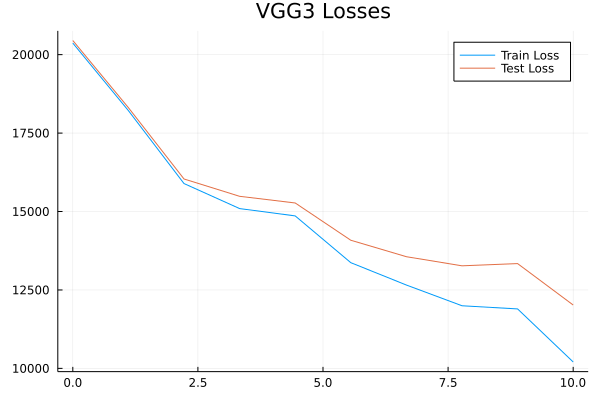

In [22]:
using Plots
plot(range(0, 10,length =10),vgg3_train_loss, labels="Train Loss")
plot!(range(0, 10,length =10),vgg3_test_loss, labels="Test Loss", title="VGG3 Losses",)

In [8]:
# PSO optimized model, 10 iterations
pso10_model = Chain(Conv((6,6), 3=>45, relu, pad=SamePad()),
    Conv((9,9), 45=>84, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Conv((7,7), 84=>87, relu, pad=SamePad()),
    Conv((4,4), 87=>92, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Conv((9,9), 92=>107, relu, pad=SamePad()),
    Conv((7,7), 107=>167, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Flux.flatten,
    Dense(2672,208,relu),
    Dropout(0.2),
    Dense(208,10),
    softmax)
#pso10_model(rand(Float32,32,32,3,10))

Chain(
  Conv((6, 6), 3 => 45, relu, pad=(3, 2, 3, 2)),  # 4_905 parameters
  Conv((9, 9), 45 => 84, relu, pad=4),  # 306_264 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((7, 7), 84 => 87, relu, pad=3),  # 358_179 parameters
  Conv((4, 4), 87 => 92, relu, pad=(2, 1, 2, 1)),  # 128_156 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((9, 9), 92 => 107, relu, pad=4),  # 797_471 parameters
  Conv((7, 7), 107 => 167, relu, pad=3),  # 875_748 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Flux.flatten,
  Dense(2672, 208, relu),               # 555_984 parameters
  Dropout(0.2),
  Dense(208, 10),                       # 2_090 parameters
  NNlib.softmax,
)                   # Total: 16 arrays, 3_028_797 parameters, 11.557 MiB.

In [14]:
pso10_train_loss, 
pso10_train_accuracy, 
pso10_test_loss, 
pso10_test_accuracy = train(pso10_model,train_loader,train_x, train_y,test_x, test_y, "PSO10");

Epoch 1 for VGG3 architecture.
  train_loss = 24162.203, train_accuracy = 0.11
  test_loss = 24325.01, test_accuracy = 0.1053
Epoch 2 for VGG3 architecture.
  train_loss = 22783.695, train_accuracy = 0.1664
  test_loss = 22865.137, test_accuracy = 0.1624
Epoch 3 for VGG3 architecture.
  train_loss = 20231.594, train_accuracy = 0.2448
  test_loss = 20237.195, test_accuracy = 0.2431
Epoch 4 for VGG3 architecture.
  train_loss = 17211.207, train_accuracy = 0.3429
  test_loss = 17416.523, test_accuracy = 0.3379
Epoch 5 for VGG3 architecture.
  train_loss = 17250.045, train_accuracy = 0.3417
  test_loss = 17561.426, test_accuracy = 0.3361
Epoch 6 for VGG3 architecture.
  train_loss = 15933.777, train_accuracy = 0.3933
  test_loss = 16501.467, test_accuracy = 0.3784
Epoch 7 for VGG3 architecture.
  train_loss = 14591.574, train_accuracy = 0.4534
  test_loss = 15305.367, test_accuracy = 0.4351
Epoch 8 for VGG3 architecture.
  train_loss = 15003.525, train_accuracy = 0.4639
  test_loss = 15784

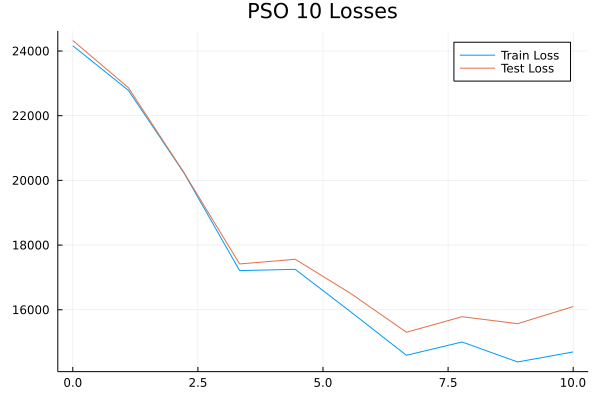

In [15]:
using Plots
plot(range(0, 10,length =10),pso10_train_loss, labels="Train Loss")
plot!(range(0, 10,length =10),pso10_test_loss, labels="Test Loss", title="PSO 10 Losses",)

In [17]:
# PSO optimized model, 10 iterations
pso10_modelb = Chain(Conv((2,2), 3=>43, relu, pad=SamePad()),
    Conv((2,2), 43=>54, relu, pad=SamePad()),
    MaxPool((4,4)),
    Dropout(0.2),
    Conv((5,5), 54=>64, relu, pad=SamePad()),
    Conv((3,3), 64=>229, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Conv((5,5), 229=>246, relu, pad=SamePad()),
    Conv((4,4), 246=>251, relu, pad=SamePad()),
    MaxPool((2,2)),
    Dropout(0.2),
    Flux.flatten,
    Dense(1004,867,relu),
    Dropout(0.2),
    Dense(867,10),
    softmax)

Chain(
  Conv((2, 2), 3 => 43, relu, pad=(1, 0, 1, 0)),  # 559 parameters
  Conv((2, 2), 43 => 54, relu, pad=(1, 0, 1, 0)),  # 9_342 parameters
  MaxPool((4, 4)),
  Dropout(0.2),
  Conv((5, 5), 54 => 64, relu, pad=2),  # 86_464 parameters
  Conv((3, 3), 64 => 229, relu, pad=1),  # 132_133 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Conv((5, 5), 229 => 246, relu, pad=2),  # 1_408_596 parameters
  Conv((4, 4), 246 => 251, relu, pad=(2, 1, 2, 1)),  # 988_187 parameters
  MaxPool((2, 2)),
  Dropout(0.2),
  Flux.flatten,
  Dense(1004, 867, relu),               # 871_335 parameters
  Dropout(0.2),
  Dense(867, 10),                       # 8_680 parameters
  NNlib.softmax,
)                   # Total: 16 arrays, 3_505_296 parameters, 13.374 MiB.

In [ ]:
pso10b_train_loss, 
pso10b_train_accuracy, 
pso10b_test_loss, 
pso10b_test_accuracy = train(pso10_modelb,train_loader,train_x, train_y,test_x, test_y, "PSO10b");

Epoch 1 for PSO10b architecture.
  train_loss = 21298.807, train_accuracy = 0.1964
  test_loss = 21275.365, test_accuracy = 0.1919
Epoch 2 for PSO10b architecture.
  train_loss = 17693.697, train_accuracy = 0.3114
  test_loss = 17782.18, test_accuracy = 0.3131
Epoch 3 for PSO10b architecture.
  train_loss = 15678.512, train_accuracy = 0.3998
  test_loss = 15824.766, test_accuracy = 0.3975
Epoch 4 for PSO10b architecture.
  train_loss = 15729.893, train_accuracy = 0.395
  test_loss = 15988.869, test_accuracy = 0.4006
Epoch 5 for PSO10b architecture.
  train_loss = 14923.878, train_accuracy = 0.4487
  test_loss = 15369.219, test_accuracy = 0.4309
Epoch 6 for PSO10b architecture.
  train_loss = 14513.223, train_accuracy = 0.4586
  test_loss = 15142.992, test_accuracy = 0.4399
